In [1]:
import torch
import numpy as np

from botorch.utils.multi_objective import is_non_dominated
from botorch.utils.transforms import normalize, unnormalize

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
from matplotlib.path import Path
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

In [2]:
def get_pareto_surface(Y, normalized_nadir, grid_length, output_bounds, dtype, device):
    num_objectives = Y.shape[-1]
    unit_vector = UnitVector(num_objectives=num_objectives, transform_label="polar")

    u = torch.linspace(0, 1, grid_length, **tkwargs)
    WX, WY = torch.meshgrid(u, u, indexing="xy")
    Z = torch.zeros(grid_length * grid_length, num_objectives, **tkwargs)

    normalized_Y = normalize(Y, output_bounds)

    for i in range(grid_length):
        for j in range(grid_length):
            index = i * grid_length + j
            Wij = torch.column_stack([WX[i, j], WY[i, j]])
            weights = unit_vector(Wij)

            s_fn = LengthScalarization(weights=weights, ref_points=normalized_nadir)
            length = s_fn(normalized_Y).max(dim=0).values
            pareto_point = normalized_nadir + length.unsqueeze(-1) * weights
            Z[index, ...] = unnormalize(pareto_point, output_bounds)

    return Z.reshape(grid_length, grid_length, num_objectives)

In [3]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
seed = 0
torch.manual_seed(seed)
data = torch.load("data/cake_data.pt")
X = data["X"]
Y = data["Y"]

model_data = torch.load("data/cake_model_data.pt")

input_bounds = torch.row_stack([X.min(dim=0).values, X.max(dim=0).values])
output_bounds = torch.row_stack([Y.min(dim=0).values, Y.max(dim=0).values])
utopia = output_bounds[1]
delta = 0.1
nadir = output_bounds[0] - delta * (output_bounds[1] - output_bounds[0])
normalized_nadir = -delta * torch.ones(Y.shape[-1], **tkwargs)

# Get Pareto points.
pareto_mask = is_non_dominated(Y)
pareto_Y = Y[pareto_mask]
pareto_X = X[pareto_mask]
non_pareto_Y = Y[~pareto_mask]
non_pareto_X = X[~pareto_mask]

# Get Pareto surface.
pareto_surface = get_pareto_surface(
    Y=Y,
    normalized_nadir=normalized_nadir,
    grid_length=400,
    output_bounds=output_bounds,
    **tkwargs
)

# Set up parallel coordinates plot.
non_pareto_XY = torch.column_stack([non_pareto_X, non_pareto_Y])
pareto_XY = torch.column_stack([pareto_X, pareto_Y])

ys = np.row_stack([non_pareto_XY, pareto_XY])
categories = np.array(
    [1 for _ in range(len(non_pareto_XY))] + [2 for _ in range(len(pareto_XY))]
)
alphas = np.array(
    [0.3 for _ in range(len(non_pareto_XY))] + [0.6 for _ in range(len(pareto_XY))]
)
linewidths = np.array(
    [2 for _ in range(len(non_pareto_XY))] + [2 for _ in range(len(pareto_XY))]
)

dys = ys.max(axis=0) - ys.min(axis=0)
ymins = ys.min(axis=0) - dys * 0.05
ymaxs = ys.max(axis=0) + dys * 0.05

zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

colors = ["dodgerblue", "crimson"]
ylabels = [
    "Wheat \n flour",
    "Spelt \n flour",
    "Sugar",
    "Chocolate",
    "Nuts",
    "Carrot",
    "Negative \n calories",
    "Taste",
    "Browning",
]

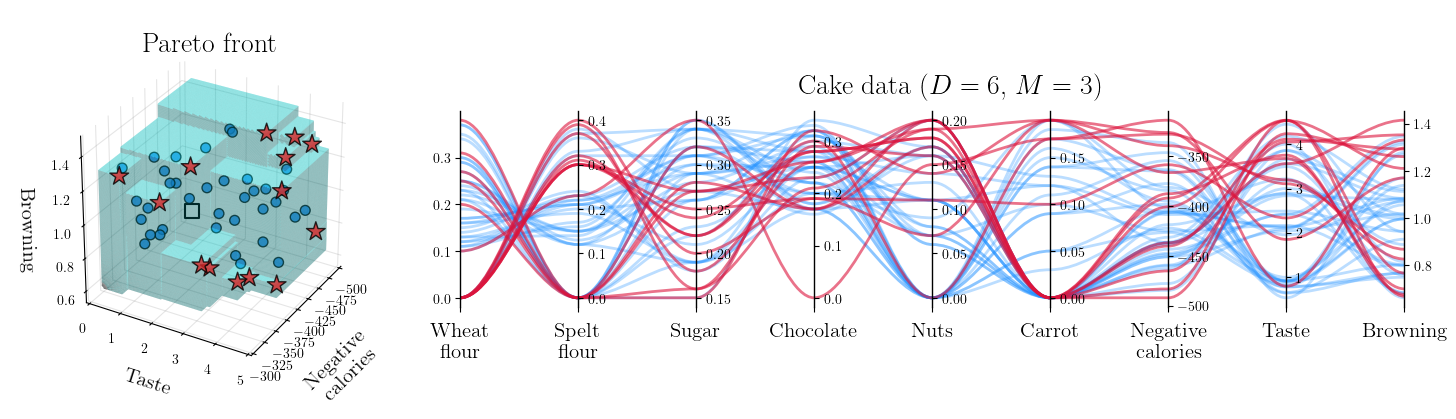

In [4]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.remove()
plt.rcParams["grid.color"] = (0.5, 0.5, 0.5, 0.2)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0.6, hspace=0.1)

gs = fig.add_gridspec(4, 12)

##################################################################################
ax = fig.add_subplot(gs[0:4, 0:4], projection="3d")

ax.scatter(
    xs=pareto_Y[:, 0],
    ys=pareto_Y[:, 1],
    zs=pareto_Y[:, 2],
    marker="*",
    color="tab:red",
    s=200,
    alpha=0.8,
    edgecolors="k",
)
ax.scatter(
    xs=non_pareto_Y[:, 0],
    ys=non_pareto_Y[:, 1],
    zs=non_pareto_Y[:, 2],
    color="dodgerblue",
    marker="o",
    s=50,
    alpha=0.8,
    edgecolors="k",
)

surf = ax.plot_surface(
    pareto_surface[..., 0],
    pareto_surface[..., 1],
    pareto_surface[..., 2],
    alpha=0.5,
    rstride=1,
    cstride=1,
    color="cyan",
    shade=True,
)

ax.scatter(
    xs=nadir[0],
    ys=nadir[1],
    zs=nadir[2],
    color="w",
    marker="s",
    linestyle="None",
    s=100,
    edgecolors="k",
    linewidth=1.5,
    zorder=5,
)

ax.view_init(30, 30)
ax.set_box_aspect(aspect=(1, 1, 1), zoom=0.8)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.pane.set_edgecolor("w")
ax.yaxis.pane.set_edgecolor("w")
ax.zaxis.pane.set_edgecolor("w")

ax.set_xlim(-500, -300)
ax.set_ylim(0, 5)
ax.set_zlim(0.55, 1.5)

ax.set_xlabel("Negative \n calories", fontsize=15, labelpad=20)
ax.set_ylabel("Taste", fontsize=15, labelpad=10)
ax.set_zlabel("Browning", fontsize=15, labelpad=10)
ax.set_title(r"Pareto front", size=20, y=0.95)
##################################################################################
main_axes = fig.add_subplot(gs[1:3, 5:12])

axes = [main_axes] + [main_axes.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    if ax != main_axes:
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_ticks_position("right")
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))
    ax.spines["left"].set_linewidth(1)
    ax.spines["right"].set_linewidth(1)

main_axes.set_xlim(0, ys.shape[1] - 1)
main_axes.set_xticks(range(ys.shape[1]))
main_axes.set_xticklabels(ylabels, fontsize=15)
main_axes.tick_params(axis="x", which="major", pad=7)
main_axes.spines["right"].set_visible(False)
main_axes.set_title(r"Cake data ($D=6$, $M=3$)", fontsize=20, x=0.52, y=1.05)

# Create Bezier curves.
for j in range(len(ys)):
    verts = list(
        zip(
            [x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
            np.repeat(zs[j, :], 3)[1:-1],
        )
    )
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = mpatches.PathPatch(
        path,
        facecolor="none",
        lw=linewidths[j],
        edgecolor=colors[categories[j] - 1],
        alpha=alphas[j],
        zorder=categories[j],
    )
    main_axes.add_patch(patch)

plt.show()